# Fundamentals of Machine Learning: Project 1

## Bernardo Costa, Fábio Almeida, Ivo Rodrigues

**Objectives**: Implement a logistic regression model and see if it works on step detection.

**Problem:** Build a Logistic Regression model to predict whether the smartphone accelerometer data corresponds to a real step or not. For this, the mobile phone should be held in a texting position.


In [46]:
#Import relevant libraries
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import pandas as pd
import sys

## Load Data

The file *RawZAxis.txt* contains the original accelerometer data for this problem, while the file *StepsOrNot.txt* contains the labels.

Load data, using function pd.read_csv from panda library. 

Extract X (the accelerometer data) and y (the labels). 

The X vector should be transformed into a matrix of columns *[k-p]* to *[k+p]*, corresponding to the real features: windows of samples (each able to contain data for a full step), as labelling individual timestamps provides no useful information.

In [47]:
# file imports
training_raw_acc = pd.read_csv("Training\TrainingAccZAxis.txt",header=None)
training_raw_dif = pd.read_csv("Training\TrainingDiffs.txt",header=None)
training_raw_stp = pd.read_csv("Training\TrainingStepsOrNot.txt",header=None)

# initial data structures
aux_xtrain_acc = training_raw_acc.values
aux_xtrain_dif = training_raw_dif.values
aux_ytrain = training_raw_stp.values

# size validation of imported data
n_xtrain_acc = len(aux_xtrain_acc)
n_xtrain_dif = len(aux_xtrain_dif)
n_ytrain = len(aux_ytrain)

if ((n_xtrain_acc != n_ytrain) or (n_xtrain_dif != n_ytrain)):
    print("IMPORTED ARRAYS HAVE DIFFERENT LENGTHS!")

### restructuring data into features and corresponding labels ###

window_size = 3 # window size must be positive and odd
if ((window_size % 2 == 0) or (window_size <= 0)):
    print("INVALID WINDOW SIZE! AUTOMATICALLY DECREMENTING 1 FROM THE SET VALUE FOR VALID EXECUTION")
    window_size -= 1
    
p = int((window_size-1)/2) # defines both window center and number of past/future samples to be evaluated

l = p # l is the control variable for the while loop below

# feature array initialization
matrix_m = n_xtrain_acc - 2*p;

Xtrain_acc = np.zeros((matrix_m,window_size))
Xtrain_dif = np.zeros((matrix_m,window_size))
ytrain = np.zeros((matrix_m,1))

aux_xtrain_acc = aux_xtrain_acc.reshape(1,len(aux_xtrain_acc))
aux_xtrain_dif = aux_xtrain_dif.reshape(1,len(aux_xtrain_dif))
aux_ytrain = aux_ytrain.reshape(len(aux_ytrain),1)

# filling the feature array
while(l <= n_xtrain_acc - p - 1):
    Xtrain_acc[l-p][:] = aux_xtrain_acc[0,(l-p):(l+p+1)]
    Xtrain_dif[l-p][:] = aux_xtrain_dif[0,(l-p):(l+p+1)]
    if(aux_ytrain[l,0] == 1):
        ytrain[l-p,0] = int(1)
    else:
        ytrain[l-p,0] = int(0)
    l += 1

if ((len(Xtrain_acc) != len(ytrain)) or (len(Xtrain_dif) != len(ytrain))):
    print("SOMETHING WENT WRONG DURING DATA RESTRUCTURING!")
else:
    print("'Phase 1: Importing and restructuring data' successfuly completed.")

        


Xtrain = np.concatenate((Xtrain_acc, Xtrain_dif), axis=1)

# update window size after concatenate
window_size = Xtrain.shape[1]
print(window_size)




### end of data restructuring ###

'Phase 1: Importing and restructuring data' successfuly completed.
6


In [48]:
### Balancing data: discarding some 'zero' examples ###
ones_examples = int(sum(ytrain))
total_zeros = len(ytrain) - ones_examples

k = 0
k2 = 0
arr_zer_index = np.zeros((total_zeros,1))

while(k < len(ytrain)):
    if ytrain[k] == 0:
        arr_zer_index[k2] = k
        k2 += 1
    k += 1
    
indexes = rd.sample(range(len(arr_zer_index)), ones_examples) # return random array indexes

# return original ones separately
aux_ones_X = np.zeros((ones_examples,window_size))
aux_ones_y = np.zeros((ones_examples,1))

k = 0
k2 = 0

while(k < len(ytrain)):
    if ytrain[k] == 1:
        aux_ones_X[k2,:] = Xtrain[k]
        aux_ones_y[k2] = ytrain[k]
        k2 += 1
    k += 1
    
# return original zeros separately
aux_zrs_X = np.zeros((total_zeros,window_size))
aux_zrs_y = np.zeros((total_zeros,1))

k = 0
k2 = 0

while(k < len(ytrain)):
    if ytrain[k] == 0:
        aux_zrs_X[k2,:] = Xtrain[k]
        aux_zrs_y[k2] = ytrain[k]
        k2 += 1
    k += 1
    
# Get corresponding zeros from indexes

k = 0
new_zeros_X = np.zeros((ones_examples,window_size))
new_zeros_y = np.zeros((ones_examples,1))

while(k < len(indexes)):
    new_zeros_X[k,:] = aux_zrs_X[indexes[k]]
    new_zeros_y[k] = aux_zrs_y[indexes[k]]
    k += 1
    
Xtrain = np.concatenate((aux_ones_X, new_zeros_X), axis=0)
ytrain = np.concatenate((aux_ones_y, new_zeros_y), axis=0)


with open('matrixy.txt', 'w') as testfile:
    for row in ytrain:
        testfile.write(' '.join([str(int(a)) for a in row]) + '\n')


with open('matrixXnew.txt', 'w') as testfile:
    for row in Xtrain:
        testfile.write(' '.join([str(a) for a in row]) + '\n')






In [49]:
#a few examples from the dataset 
training_raw_acc.columns = ["Accelerometer Z Axis"]
training_raw_dif.columns = ["Accelerometer Diffs Vector"]

training_raw_acc.head()
#training_raw_dif.head()

,Accelerometer Z Axis
0,-0.879346
1,-1.048041
2,-0.815021
3,-0.868610
4,-0.720197


In [50]:
training_raw_acc.describe()
#training_raw_dif.describe()

,Accelerometer Z Axis
count,8100.000000
mean,-0.846012
std,0.205068
min,-1.852814
25%,-0.915610
50%,-0.785253
75%,-0.711870
max,-0.390248


### Sigmoid function

Complete *sigmoid* function that computes $ g(z) = \frac{1}{(1+e^{-z})}$. 


In [51]:
def sigmoid(z):
    """
    return the sigmoid of z
    """
    
    gz= 1/(1+np.exp(-z))
    
    return gz

In [52]:
# Test the sigmoid function for z=0 => ANSWER =0.5 
sigmoid(0)

0.5

### Compute the Cost Function and Gradient

Recall that the Logistic Regression model is defined as:    $h_{\theta}(x^{(i)})=  \frac{1}{1+e^{-\theta (x^{(i)})}}$

The cost function in Logistic Regression is: $J(\theta) = \frac{1}{m} \sum_{i=1}^{m} [ -y^{(i)}log(h_{\theta}(x^{(i)})) - (1 - y^{(i)})log(1 - (h_{\theta}(x^{(i)}))]$

The gradient of $J(\theta)$ is a vector of the same length as $\theta$  where the jth element (for j = 0, 1,…. n) is defined as:
$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_{\theta}(x^{(i)}) - y^{(i)})x_j^{(i)}$

Complete function *costFunction* to return $J(\theta)$ and the gradient ((partial derivative of $J(\theta)$ with respect to each $\theta$) for logistic regression. 


In [53]:
def costFunction(theta, X, y):
    """
    Takes in numpy array theta, x and y and return the logistic regression cost function and gradient
    """
    
    #number of training examples 
    m=len(y)
    
    #vector of the model predictions for all training examples   
    h = sigmoid(np.dot(X,theta))
         
    error = (-y * np.log(h)) - ((1-y)*np.log(1-h))

    #cost function
    cost = 1/m * sum(error)
       
    #vector of gradients of all model parameters theta   
    grad = 1/m * np.dot(X.transpose(),(h - y))
    
    return cost[0] , grad


### Feature normalization
Apply the same normalization as in Lab 2 (PART 2 Multivariable Linear Regression). 

In [54]:
def featureNormalization(X):
    """
    Take in numpy array of X values and return normalize X values,
    the mean and standard deviation of each feature
    """
    mean= np.mean(X,axis=0)
    std= np.std(X,axis=0)
    
    X_norm = (X-mean)/std
    
    return X_norm , mean , std

In [55]:
#Run featureNormalization to normalize X, store the means and stds.

X, X_mean, X_std = featureNormalization(Xtrain)
m = len(X)
#After normalizing the features, add an extra column of 1's corresponding to x0 = 1.
X= np.append(np.ones((m,1)),X.reshape(m,window_size),axis=1)


# Inicialize vector theta = 0
initial_theta = np.zeros((window_size+1,1))

#Run costFunction
cost, grad= costFunction(initial_theta, X, ytrain)

print("Cost of initial theta is",round(cost,3) )   # ANSWER: Cost of initial theta is 0.693
print("Gradient at initial theta (zeros):",grad)  #ANSWER: Gradient at initial theta (zeros): [[-0.1 ] [-0.28122914] [-0.25098615]]

Cost of initial theta is 0.693
Gradient at initial theta (zeros): [[ 0.        ]
 [ 0.22109073]
 [ 0.30587051]
 [ 0.19491151]
 [ 0.25824475]
 [ 0.07031758]
 [-0.09381708]]


### Gradient Descent
Implement gradient descent in the function *gradientDescent*. 
The gradient descent algorithm is very similar to linear regression. 

The only difference is that the hypothesis is now the sigmoid function:  $h_{\theta}(x)=  \frac{1}{1+e^{-\theta^T x}}$

The loop structure is written, you need to supply the updates for $\theta$  within each iteration.

In [56]:
def gradientDescent(X,y,theta,alpha,num_iters):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    #number of training examples
    m=len(y)
    J_history =[]
    
    for i in range(num_iters):
        cost, grad = costFunction(theta, X, y)
        theta = theta-(alpha*grad)
        J_history.append(cost)
    
    return theta , J_history

In [57]:
# Run gradientDescent with learning rate 0.5 and 400 iterations. 
theta , J_history = gradientDescent(X,ytrain,initial_theta,0.5,400)

print("Theta optimized by gradient descent:",theta)

print("The cost for the optimized theta:",round(J_history[-1],3))  #ANSWER: The cost for the optimized theta: 0.205

Theta optimized by gradient descent: [[ 0.53275366]
 [-1.46292223]
 [-1.86926103]
 [-1.46020588]
 [-0.63301762]
 [-0.33938529]
 [ 0.35472733]]
The cost for the optimized theta: 0.279


### Plot the Cost Function 
Choose 400 iterations. Try different values of the learning  rate = [0.01, 0.1, 0.5, 1].

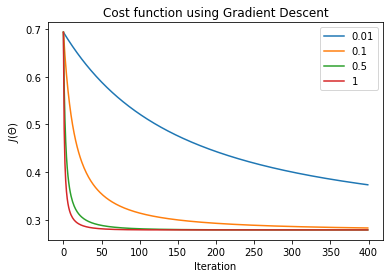

In [58]:
lr=[0.01, 0.1, 0.5, 1]
for i in lr:
    theta, J_history = gradientDescent(X, ytrain, initial_theta, i, 400)
    plt.plot(range(400), J_history)

plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")
plt.legend(["0.01","0.1","0.5","1"])

### Prediction

For a given step window, corresponding to a real valid step, use the learned model to compute the step ocurrence probability.

In [59]:
# testing a real step
#x_test = np.array([-1.028643, -1.489803, -0.7642385, -0.237778, -0.4611599, 0.7255644])

# testing a non-step
x_test = np.array([-0.936594, -0.5905409, -0.6264395, 0.5687029, 0.3460531, -0.03589851])


#Normalize the values
x_test = (x_test - X_mean)/X_std
#Add one
x_test = np.append(np.ones(1),x_test)
#Compute the prediction (the probability for admission)
prob = sigmoid(x_test.dot(theta))

print("For the given window, the probability of a step ocurrence is: ",(prob[0]*100),"%")

For the given window, the probability of a step ocurrence is:  0.576919398240608 %


### Accuracy on training set 

Evaluate how well the learned model predicts on the training set. 

Your task is to complete the function *classifierPredict*. 

The *classifierPredict* function returns a boolean array with True if the probability of admission into university is more than 0.5 and False otherwise. Taking the sum(p==y) adds up all instances where it correctly predicts the given y values (the labels).

In [60]:
def classifierPredict(theta,X):
    """
    take in numpy array of theta and X and predict the class 
    """
    predictions = X.dot(theta)
    bool_values = (predictions > 0.5)
    
    return bool_values.astype(int)

In [61]:
p=classifierPredict(theta,X)
p_format = np.copy(p)
undetected_steps = 0
correct_steps = 0
correct_nonsteps = 0
fake_steps = 0
total_steps = int(sum(ytrain))

# where there are real steps (3 consecutive ones), verify the ocurrence of ones
# and then, if there are ones in a 3-sample window, fill these 3 samples with ones

k = 0;
#while (k < len(ytrain)-3):
while (k < len(ytrain)):
    if (ytrain[k] == 1):
        #if((p[k] == 1) or (p[k+1] == 1) or (p[k+2] == 1)):
        if(p[k] == 1):
            p_format[k] = 1
            #p_format[k+1] = 1
            #p_format[k+2] = 1
            correct_steps += 1
        else:
            undetected_steps +=1
        #k += 3
    else:
        if(p[k] == 1):
            fake_steps += 1
        else:
            correct_nonsteps += 1
        # k += 1
    k += 1

print("Training accuracy:", 100*(sum(p_format==ytrain)[0])/len(ytrain),"%")
print("Correct steps:", int(correct_steps))
print("Correct non-steps:", correct_nonsteps)
print("Fake steps:", int(fake_steps))
print("Undetected steps:", int(np.ceil(undetected_steps)))
print("Total steps:", total_steps)


Training accuracy: 88.73333333333333 %
Correct steps: 2490
Correct non-steps: 2834
Fake steps: 166
Undetected steps: 510
Total steps: 3000


## Validation of the computed model on the test set

In [18]:
# file imports
testing_raw_acc = pd.read_csv("Testing\TestingAccZAxis.txt",header=None)
testing_raw_dif = pd.read_csv("Testing\TestingDiffs.txt",header=None)
testing_raw_stp = pd.read_csv("Testing\TestingStepsOrNot.txt",header=None)

# initial data structures
aux_xtest_acc = testing_raw_acc.values
aux_xtest_dif = testing_raw_dif.values
aux_ytest = testing_raw_stp.values

# size validation of imported data
n_xtest_acc = len(aux_xtest_acc)
n_xtest_dif = len(aux_xtest_dif)
n_ytest = len(aux_ytest)

if ((n_xtest_acc != n_ytest) or (n_xtest_dif != n_ytest)):
    print("IMPORTED ARRAYS HAVE DIFFERENT LENGTHS!")

### restructuring data into features and corresponding labels ###

window_size = 3 # window size must be positive and odd
if ((window_size % 2 == 0) or (window_size <= 0)):
    print("INVALID WINDOW SIZE! AUTOMATICALLY DECREMENTING 1 FROM THE SET VALUE FOR VALID EXECUTION")
    window_size -= 1
    
p = int((window_size-1)/2) # defines both window center and number of past/future samples to be evaluated

l = p # l is the control variable for the while loop below

# feature array initialization
matrix_m = n_xtest_acc - 2*p;

Xtest_acc = np.zeros((matrix_m,window_size))
Xtest_dif = np.zeros((matrix_m,window_size))
ytest = np.zeros((matrix_m,1))

aux_xtest_acc = aux_xtest_acc.reshape(1,len(aux_xtest_acc))
aux_xtest_dif = aux_xtest_dif.reshape(1,len(aux_xtest_dif))
aux_ytest = aux_ytest.reshape(len(aux_ytest),1)

# filling the feature array
while(l <= n_xtest_acc - p - 1):
    Xtest_acc[l-p][:] = aux_xtest_acc[0,(l-p):(l+p+1)]
    Xtest_dif[l-p][:] = aux_xtest_dif[0,(l-p):(l+p+1)]
    if(aux_ytest[l,0] == 1):
        ytest[l-p,0] = int(1)
    else:
        ytest[l-p,0] = int(0)
    l += 1

if ((len(Xtest_acc) != len(ytest)) or (len(Xtest_dif) != len(ytest))):
    print("SOMETHING WENT WRONG DURING DATA RESTRUCTURING!")
else:
    print("'Testing data: Importing and restructuring data' successfuly completed.")


Xtest = np.concatenate((Xtest_acc, Xtest_dif), axis=1)

# update window size after concatenate
window_size = Xtest.shape[1]
print(window_size)

with open('matrixytest.txt', 'w') as testfile:
    for row in ytest:
        testfile.write(' '.join([str(int(a)) for a in row]) + '\n')


with open('matrixXtest.txt', 'w') as testfile:
    for row in Xtest:
        testfile.write(' '.join([str(a) for a in row]) + '\n')

### end of data restructuring ###

'Testing data: Importing and restructuring data' successfuly completed.
6


In [62]:
m = len(Xtest)
X, X_mean, X_std = featureNormalization(Xtest)
new_Xtest = np.append(np.ones((m,1)),X.reshape(m,window_size),axis=1)
p=classifierPredict(theta,new_Xtest)
p_format = np.copy(p)
undetected_steps = 0
correct_steps = 0
correct_nonsteps = 0
fake_steps = 0
total_steps = int(sum(ytest))

# where there are real steps (3 consecutive ones), verify the ocurrence of ones
# and then, if there are ones in a 3-sample window, fill these 3 samples with ones
k = 0;
#while (k < len(ytrain)-3):
while (k < len(ytest)):
    if (ytest[k] == 1):
        #if((p[k] == 1) or (p[k+1] == 1) or (p[k+2] == 1)):
        if(p[k] == 1):
            p_format[k] = 1
            #p_format[k+1] = 1
            #p_format[k+2] = 1
            correct_steps += 1
        else:
            undetected_steps +=1
        #k += 3
    else:
        if(p[k] == 1):
            fake_steps += 1
        else:
            correct_nonsteps += 1
        # k += 1
    k += 1

print("Training accuracy:", 100*(sum(p_format==ytest)[0])/len(ytest),"%")
print("Correct steps:", int(correct_steps))
print("Correct non-steps:", correct_nonsteps)
print("Fake steps:", int(fake_steps))
print("Undetected steps:", int(np.ceil(undetected_steps)))
print("Total steps:", total_steps)

'''
with open('testmatrixy.txt', 'w') as testfile:
    for row in ytest:
        testfile.write(' '.join([str(int(a)) for a in row]) + '\n')


with open('testmatrixp.txt', 'w') as testfile:
    for row in p_format:
        testfile.write(' '.join([str(a) for a in row]) + '\n')
'''

Training accuracy: 88.46431146359048 %
Correct steps: 519
Correct non-steps: 708
Fake steps: 79
Undetected steps: 81
Total steps: 600


"\nwith open('testmatrixy.txt', 'w') as testfile:\n    for row in ytest:\n        testfile.write(' '.join([str(int(a)) for a in row]) + '\n')\n\n\nwith open('testmatrixp.txt', 'w') as testfile:\n    for row in p_format:\n        testfile.write(' '.join([str(a) for a in row]) + '\n')\n"

## sklearn library to solve the same problem 

In [20]:
from sklearn.linear_model import LogisticRegression
#x_test = np.array([-0.8717815,-0.8625095,-0.8654374,-0.8654374,-0.809653,-0.800137,-0.8362795,-0.8481135,-0.827709,-0.827099,-0.8328635,-0.8328635,-0.810507,-0.793793,-0.8318875,-0.8805655,-0.927078,-0.913536,-0.913536,-0.8561655,-0.807823,-0.793305,-0.778787,-0.7671665,-0.774517
#])
x_test = np.array([-0.67527, -0.797575, -1.4073, -0.01772046, -0.122305, -0.6097255])

y_new = ytrain.reshape(len(ytrain), 1)
x_test = x_test.reshape(1,len(x_test))
logitN = LogisticRegression()

# Treina o modelo
logitN.fit(Xtrain,y_new)

# Prediction of step
new_evaluation = logitN.predict(Xtest)
print(logitN.score(Xtrain, y_new))


print(new_evaluation)

0.896
[1. 0. 0. ... 0. 0. 0.]


C:\Users\brinc\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
